# Final Project- Instacart Predictions

“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on November 18, 2019.

## Group Name:
HAM

## Group Members:
- Andy Cheon
- Meng (Marine) Lin
- Hannah Lyon

In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import compose
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
import numpy as np

## Ask:

How can we predict the items that an Instacart user is likely to repurchase?

## Acquire:

In [2]:
df = pd.read_csv('data/instacart.csv')
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


In [3]:
df = df.dropna() 

In [4]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31741038 entries, 0 to 33819105
Data columns (total 15 columns):
order_id                  31741038 non-null int64
product_id                31741038 non-null int64
add_to_cart_order         31741038 non-null int64
reordered                 31741038 non-null int64
product_name              31741038 non-null object
aisle_id                  31741038 non-null int64
department_id             31741038 non-null int64
aisle                     31741038 non-null object
department                31741038 non-null object
user_id                   31741038 non-null int64
eval_set                  31741038 non-null object
order_number              31741038 non-null int64
order_dow                 31741038 non-null int64
order_hour_of_day         31741038 non-null int64
days_since_prior_order    31741038 non-null float64
dtypes: float64(1), int64(10), object(4)
memory usage: 3.8+ GB


## Process:

In [7]:
def data_clean(df):
    df = pd.get_dummies(df, columns=['department_id'], drop_first=True)
    
    # find total numbers of orders
    temp = df.groupby('user_id').max()[['order_number']].reset_index()
    df = df.merge(temp, how='left', left_on='user_id', right_on='user_id')
    
    # weekend flag
    df['weekend'] = 0
    df.loc[(df['order_dow'] == 5) | (df['order_dow'] == 6),'weekend'] = 1
    
    staples = {
    'dairy eggs' : 1,
    'produce' : 1,
    'pantry' : 0,
    'meat seafood' : 1,
    'bakery' : 0,
    'personal care' : 0,
    'snacks' : 0,
    'breakfast' : 0,
    'beverages' : 0,
    'deli' : 0,
    'household' : 0,
    'international' : 0,
    'dry goods pasta' : 1,
    'frozen' : 0,
    'canned goods' : 0,
    'babies' : 0,
    'pets' : 0,
    'alcohol' : 0,
    'bulk' : 0,
    'missing' : 0,
    'other' : 0
    }
    
    df.loc[:, 'department_is_staple'] = df['department'].apply(lambda x: staples[x])
    
    df.loc[:, 'product_is_organic'] = 0
    df.loc[df.product_name.apply(lambda x: 'organic' in x.lower()), 'product_is_organic'] = 1
    
    df.drop(['product_name', 'aisle', 'department'], axis=1, inplace=True)
    return df

In [8]:
df = data_clean(df)

In [9]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,user_id,eval_set,order_number_x,order_dow,order_hour_of_day,...,department_id_16,department_id_17,department_id_18,department_id_19,department_id_20,department_id_21,order_number_y,weekend,department_is_staple,product_is_organic
0,2,33120,1,1,86,202279,prior,3,5,9,...,1,0,0,0,0,0,9,1,1,1
1,2,28985,2,1,83,202279,prior,3,5,9,...,0,0,0,0,0,0,9,1,1,1
2,2,9327,3,0,104,202279,prior,3,5,9,...,0,0,0,0,0,0,9,1,0,0
3,2,45918,4,1,19,202279,prior,3,5,9,...,0,0,0,0,0,0,9,1,0,0
4,2,30035,5,0,17,202279,prior,3,5,9,...,0,0,0,0,0,0,9,1,0,0


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Non Reordered Versus Reordered Products')

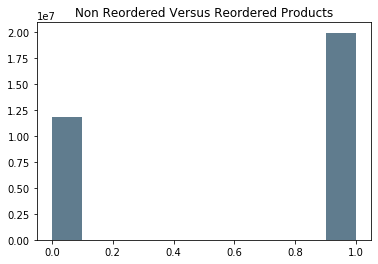

In [28]:
plt.hist(df['reordered'], color='#607c8e')
plt.title('Non Reordered Versus Reordered Products')

Text(0.5, 1.0, 'Non Organic Versus Organic Products')

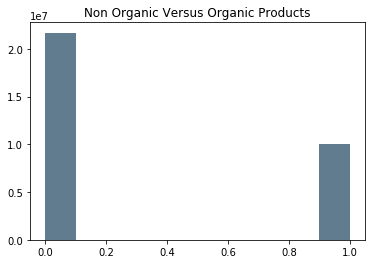

In [30]:
plt.hist(df['product_is_organic'], color='#607c8e')
plt.title('Non Organic Versus Organic Products')

Text(0.5, 1.0, 'Non Staple Versus Staple Products')

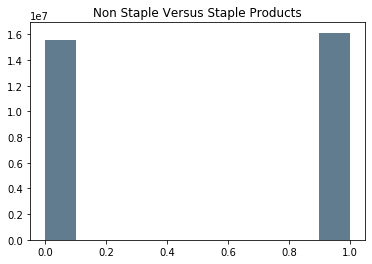

In [31]:
plt.hist(df['department_is_staple'], color='#607c8e')
plt.title('Non Staple Versus Staple Products')